# K-means and Alphabet
Imports

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import psycopg2
import collections
import string
from psycopg2.extensions import register_adapter, AsIs
import wfdb
np.set_printoptions(suppress=True)

Methods

In [2]:
def obtainMeasures(dbname="mimic",withcentroid=False,nullCentroid=False) :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    limit = "" if withcentroid else " LIMIT 10000 "
    null = " AND centroid is null" if nullCentroid else "" 
    select_stament = ("SELECT DISTINCT q_i-t_i AS qt,t_i-s_i AS ts,s_i-r_i AS sr,centroid FROM waveformqrst "
                      " WHERE t_i>s_i AND q_i-t_i>-1000 AND q_i is not null AND t_i is not null AND s_i is not null "
                      " AND r_i is not null "+null+limit
    )
    ## "OFFSET floor(random()* 630702) limit 100000"
    ##+"limit (select count(1)/2 from waveformqrst)"
    cur.execute(select_stament)
    waves = []
    for row in cur :
        qt = row[0]
        ts = row[1]
        sr = row[2]
        centroid = row[3]
        if withcentroid :
#            centroid = 10 if row[3] is None else row[3]
            waves.append([qt,ts,sr,centroid])
        else :
            waves.append([qt,ts,sr])
    conn.close()
    return waves

In [3]:
fig_size = [12,9]
plt.rcParams["figure.figsize"] = fig_size
def printKmeans(kmeans) :
    labels, values = zip(*collections.Counter(kmeans.labels_).items())
    indexes = np.arange(len(labels))
    width = 0.5
    fig, ax = plt.subplots() 
    for i, v in enumerate(values):
        ax.text(i-0.1,v+1, str(v), color='blue', fontweight='bold')
    plt.bar(indexes, values, width)
    plt.title('Cantidad de Latidos por centroide')
    plt.ylabel('Cantidad de latidos')
    plt.xlabel('Centroides')
    plt.xticks(indexes + width * 0.01, labels)
    plt.show()

Implementation

In [4]:
waves = obtainMeasures()
X = np.array(waves)

In [5]:
centroid = np.array([
    [-148.79672419,112.41971337,32.03392805],
    [-137.53665229,44.13171305,89.25362603],
 [-233.35639029,176.5231333,52.41777371],
 [-266.64928292,69.1303781,192.93350717],
 [-354.62881356,312.50338983,38.17966102],
 [-465.00403226,96.87903226,363.77822581],
 [-673.91472868,558.31782946,111.51937984],
 [-780.22123894,74.20353982,701.83185841]]
)
kmeans = KMeans(n_clusters=8,init=centroid,n_init=1
               ).fit(X)

In [6]:
centroid = kmeans.cluster_centers_
print(centroid)

[[-151.69459232  114.34547492   32.94228075]
 [-142.02922078   44.73336039   93.10876623]
 [-235.62830189  179.29103774   51.93396226]
 [-268.10883483   68.50704225  195.0396927 ]
 [-358.03521127  314.67077465   39.36091549]
 [-464.53174603   95.54365079  364.67063492]
 [-675.4351145   560.27480916  111.06870229]
 [-781.80869565   73.77391304  703.83478261]]


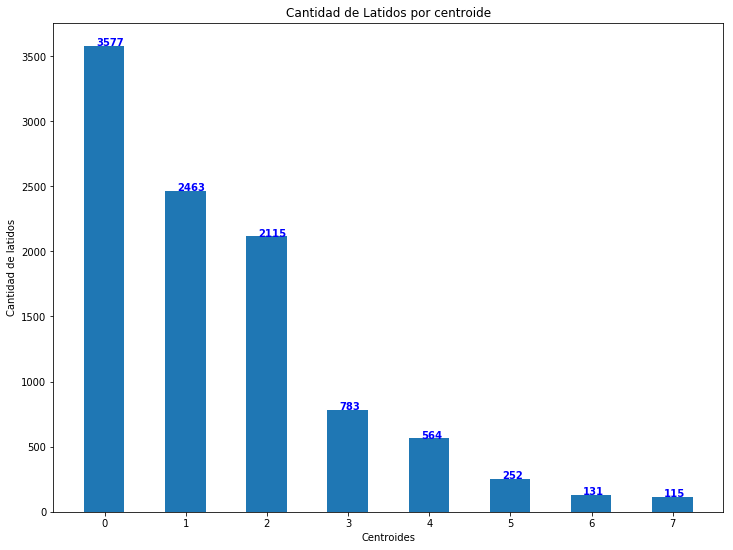

In [7]:
printKmeans(kmeans)

Update Waves with the K-means

In [20]:
def updateQRST(wave,centroid,conn) :
    cur = conn.cursor()
    select_stament = "UPDATE waveformqrst SET centroid = (%s) WHERE q_i-t_i = (%s) AND t_i-s_i =(%s) AND s_i-r_i = (%s)"
    cur.execute(select_stament, (centroid,int(wave[0]),int(wave[1]),int(wave[2]),))
    conn.commit()
waves = obtainMeasures(withcentroid=True,nullCentroid=True)
conn = psycopg2.connect("dbname=mimic")
waves = waves[:100]
numberToAlpha = dict(enumerate(string.ascii_lowercase, 0))
for wave in waves :
    if wave[3] is None : # or centroid !=wave[3]) :
        centValue = numberToAlpha[kmeans.predict([[wave[0],wave[1],wave[2]]])[0]]
        updateQRST(wave,centValue,conn)
        #print("None")
conn.close()

In [9]:
kmeans.predict([[-1,-18,14],[-43,28,10],[-49,37,7],[-65,46,14], [-26,13,8],[-96,72,19]
                ,[-247,236,11],[-1242,  1136,   101]])

array([1, 1, 1, 1, 1, 0, 2, 6], dtype=int32)

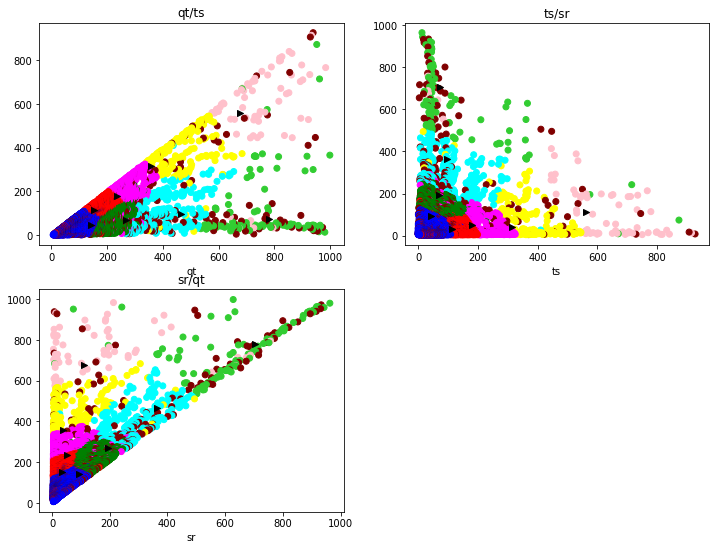

In [10]:
def centroidColor(clist) :
    color = {
        'a': "blue",
        'b': "red",
        'c': "green",
        'd': "magenta",
        'e': "cyan",
        'f': "yellow",
        'g': "limegreen", 
        'h': "pink",
        None : "maroon"
    }
    return [color[x] for x in clist]
#import matplotlib.patches as mpatches
waves = obtainMeasures(withcentroid=True)
qt = np.array([-item[0] for item in waves])
ts = np.array([item[1] for item in waves])
sr = np.array([item[2] for item in waves])
color = np.array([item[3] for item in waves])
qtc = np.array([-int(item[0]) for item in centroid])
tsc = np.array([item[1] for item in centroid])
src = np.array([item[2] for item in centroid])
color = centroidColor(color)
fig = plt.figure()
ax = fig.add_subplot(221)
ax.set_title("qt/ts")
ax.set_xlabel("qt")
ax.scatter(qt,ts, c=color)
ax.scatter(qtc,tsc,c='black', marker=">")
ax = fig.add_subplot(222)
ax.set_title("ts/sr")
ax.set_xlabel("ts")
ax.scatter(ts,sr, c=color)
ax.scatter(tsc,src,c='black', marker=">")
ax = fig.add_subplot(223)
ax.set_title("sr/qt")
ax.set_xlabel("sr")
ax.scatter(sr,qt, c=color)
ax.scatter(src,qtc,c='black', marker=">")
plt.show()

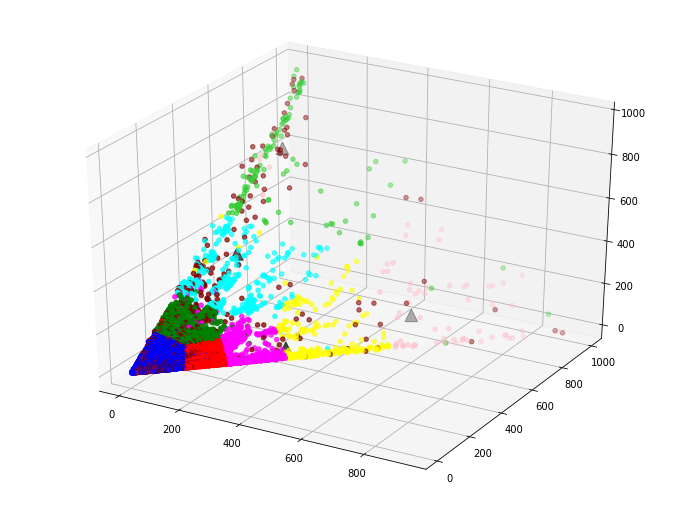

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts,qt, sr, c=color)
ax.scatter(tsc,qtc, src, c='black',marker="^",s=160)
plt.show()

In [12]:
def findCentroid(centroid,window=0,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    qt = str(centroid[0])
    ts = str(centroid[1])
    sr = str(centroid[2])
    strWin = str(window)
    select_stament = ("SELECT qrst.subject_id,qrst.recorddate,signame,fs,signallength,centroid,wave,q_amp,q_i,r_amp,r_i,s_amp,s_i,t_amp,t_i "
                      " FROM waveformqrst qrst "
                      " LEFT JOIN waveformfields fields"
                      " ON qrst.subject_id = fields.subject_id "
                      " AND qrst.recorddate = fields.recorddate "
                      " WHERE "
                      " (q_i-t_i between floor("+qt+")-"+strWin+" and ceil("+qt+")+"+strWin+")"
                      " AND (t_i-s_i between floor("+ts+")-"+strWin+" and ceil("+ts+")+"+strWin+")"
                      " AND (s_i-r_i between floor("+sr+")-"+strWin+" and ceil("+sr+")+"+strWin+")"
                      " LIMIT 1")
    cur.execute(select_stament)
    notFound = True
    for row in cur :
        notFound = False
        patient = "p"+str(row[0]).zfill(6)
        onda = patient+'-'+row[1]
        carpeta = patient[:3]+"/"+patient
        qrst = [[row[7],row[8]],[row[9],row[10]],[row[11],row[12]],[row[13],row[14]]]
#        print(centroid,row,patient,onda,carpeta,window)
        return {"subject_id":row[0],"recorddate":row[1],"fs":row[3],"onda":onda,"carpeta":carpeta,
                      "signalII":row[2].index("II"),"signallength":row[4],"centroid":row[5],
               "wave":row[6],"begin":row[8],"end":row[14],"qrst":qrst}
    if(notFound) :
        return findCentroid(value,window=window+1)

In [13]:
def updateOriginalWave(subject_id,recorddate,begin,end,originalWave):
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = "UPDATE waveformqrst SET wave = (%s) WHERE subject_id = (%s) AND recorddate =(%s) AND q_i = (%s) AND t_i = (%s)"
    cur.execute(select_stament, (originalWave.tolist(),subject_id,recorddate,begin,end,))
    conn.commit()

In [26]:
def printCentroid(wave) :
    signalSize = 1800000
    carpeta = wave["carpeta"]
    onda = wave["onda"]
    signalII = wave["signalII"]
    fs = wave["fs"]
    subject_id = wave["subject_id"]
    recorddate = wave["recorddate"]
    begin = wave["begin"]
    end = wave["end"]
    originalWave = wave["wave"]
    qrst = wave["qrst"]
    amp =[item[0] for item in qrst]
    time = [item[1]-int(begin) for item in qrst]
    if originalWave is None :
        print("searching new Centroid")
        signal = wfdb.rdsamp(onda,pbdir='mimic3wdb/matched/'+carpeta,channels =[signalII]).p_signals
        signalNan = signal[~np.isnan(signal)]
        subsignal = signalNan[-1800000:]
        originalWave = subsignal[begin:begin+100]
        updateOriginalWave(subject_id,recorddate,begin,end,originalWave)
#    print(carpeta,onda,subject_id,recorddate,qrst)
    cen = wave["centroid"] if wave["centroid"] is not None else "z"
    ax.set_title(cen+" subject:"+str(subject_id))
#    plt.scatter(time,amp,c="red")
    ax.plot(originalWave[:100])
#    print(subsignal)


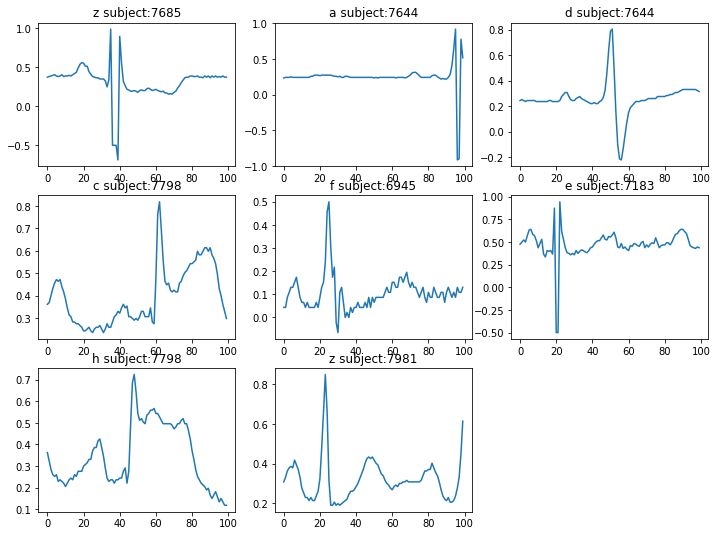

In [28]:
fig = plt.figure()
inx= 1
for value in centroid :
    ax = fig.add_subplot(3,3,inx)
    wave = findCentroid(value)
    printCentroid(wave)
    inx=inx+1
plt.show()